# Sentiment analysis

In [1]:
import re
import time
from collections import OrderedDict

import numpy as np
import torchtext
from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
labels = ['neg', 'pos']

In [3]:
def clean_text(text):
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [4]:
train_data, test_data = torchtext.datasets.IMDB.splits(
    torchtext.data.Field(tokenize=lambda s: s),
    torchtext.data.Field(tokenize=lambda s: s),
    root='../data/imdb')

train_texts, val_texts, train_y, val_y = train_test_split(
    [clean_text(s.text) for s in train_data],
    np.array([labels.index(s.label) for s in train_data]),
    test_size=0.1, random_state=1234)

test_texts = [clean_text(s.text) for s in test_data]
test_y = np.array([labels.index(s.label) for s in test_data])

In [5]:
data = OrderedDict()
for name, y in (('training', train_y), ('validation', val_y), ('test', test_y)):
    _, counts = np.unique(y, return_counts=True)
    data[f'{name} set'] = OrderedDict([(labels[i], c) for i, c in enumerate(counts)])
    data[f'{name} set']['total'] = y.shape[0]
display(DataFrame(data).T)

,neg,pos,total
training set,11208,11292,22500
validation set,1292,1208,2500
test set,12500,12500,25000


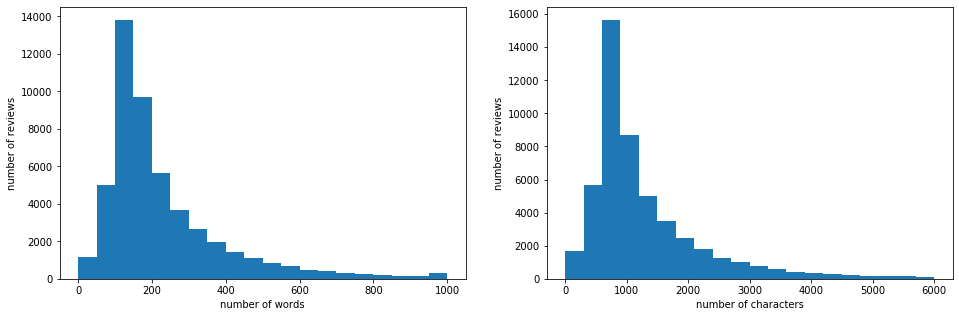

In [6]:
plt.figure(figsize=(16, 5))
for i, (type_, len_fn, range_) in enumerate([
        ('words', lambda t: len(t.split()), (0, 1000)),
        ('characters', len, (0, 6000))]):
    lens = [len_fn(t) for t in (*train_texts, *val_texts, *test_texts)]
    plt.subplot(1, 2, i + 1)
    plt.hist(lens, bins=20, range=range_)
    plt.xlabel(f'number of {type_}')
    plt.ylabel('number of reviews')
plt.show()

In [7]:
models = OrderedDict()

In [8]:
class SKLearnClassifier:

    def __init__(self, model):
        self.vectorizer = CountVectorizer(strip_accents='ascii', lowercase=True)
        self.model = model

    def fit(self, train_texts, train_y):
        start = time.time()
        train_x = self.vectorizer.fit_transform(train_texts)
        self.model.fit(train_x, train_y)
        print(f'Finished training in {time.time() - start:.2f}s')

    def predict(self, texts):
        x = self.vectorizer.transform(texts)
        return self.model.predict(x)

In [9]:
models['random forest'] = SKLearnClassifier(
    RandomForestClassifier(n_estimators=150, max_depth=25, n_jobs=-1))

In [10]:
models['random forest'].fit(train_texts, train_y)

Finished training in 5.14s


In [11]:
data = OrderedDict()
for name, model in models.items():
    data[name] = OrderedDict([
        ('training set', f'{accuracy_score(train_y, model.predict(train_texts)):.3f}'),
        ('validation set', f'{accuracy_score(val_y, model.predict(val_texts)):.3f}'),
        ('test set', f'{accuracy_score(test_y, model.predict(test_texts)):.3f}')])
display(DataFrame(data))

,random forest
test set,0.846
training set,0.956
validation set,0.850
